# 多层感知机的从零开始实现
:label:`sec_mlp_scratch`

我们已经在 :numref:`sec_mlp`中描述了多层感知机（MLP），
现在让我们尝试自己实现一个多层感知机。
为了与之前softmax回归（ :numref:`sec_softmax_scratch` ）
获得的结果进行比较，
我们将继续使用Fashion-MNIST图像分类数据集
（ :numref:`sec_fashion_mnist`）。


In [17]:
import torch
from torch import nn
from d2l import torch as d2l

# 尝试获取第一个GPU，如果没有，则使用CPU
device = d2l.try_gpu() 
print(f'正在使用的设备: {device}')
print(torch.cuda.is_available()) # 如果输出 True，说明环境配置正确
!nvidia-smi

正在使用的设备: cpu
False
Mon Oct 20 19:32:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.15                 Driver Version: 581.15         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090      WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   32C    P8             31W /  350W |    1253MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------

In [18]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

回想一下，Fashion-MNIST中的每个图像由
$28 \times 28 = 784$个灰度像素值组成。
所有图像共分为10个类别。
忽略像素之间的空间结构，
我们可以将每个图像视为具有784个输入特征
和10个类的简单分类数据集。
首先，我们将[**实现一个具有单隐藏层的多层感知机，
它包含256个隐藏单元**]。
注意，我们可以将这两个变量都视为超参数。
通常，我们选择2的若干次幂作为层的宽度。
因为内存在硬件中的分配和寻址方式，这么做往往可以在计算上更高效。

我们用几个张量来表示我们的参数。
注意，对于每一层我们都要记录一个权重矩阵和一个偏置向量。
跟以前一样，我们要为损失关于这些参数的梯度分配内存。


In [19]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 128 

# 单隐藏层
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens1, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens1, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens1, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2] # 单隐藏层

# # 两个隐藏层
# W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens1, requires_grad=True) * 0.01)
# b1 = nn.Parameter(torch.zeros(num_hiddens1, requires_grad=True))
# W2 = nn.Parameter(torch.randn(num_hiddens1, num_hiddens2, requires_grad=True) * 0.01)
# b2 = nn.Parameter(torch.zeros(num_hiddens2, requires_grad=True))
# W3 = nn.Parameter(torch.randn(num_hiddens2, num_outputs, requires_grad=True) * 0.01)
# b3 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

# # 注意更新参数列表
# params = [W1, b1, W2, b2, W3, b3] # 双隐藏层

## 激活函数

为了确保我们对模型的细节了如指掌，
我们将[**实现ReLU激活函数**]，
而不是直接调用内置的`relu`函数。


In [20]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

## 模型

因为我们忽略了空间结构，
所以我们使用`reshape`将每个二维图像转换为一个长度为`num_inputs`的向量。
只需几行代码就可以(**实现我们的模型**)。


In [21]:
def net(X):
    # 单隐藏层
    X = X.reshape((-1, num_inputs))
    H = relu(X @ W1 + b1)  # 这里“@”代表矩阵乘法
    return H @ W2 + b2

    # # 两个隐藏层
    # X = X.reshape((-1, num_inputs))
    # H1 = relu(X @ W1 + b1)  # 这里“@”代表矩阵乘法
    # H2 = relu(H1 @ W2 + b2)
    # return H2 @ W3 + b3

## 损失函数

由于我们已经从零实现过softmax函数（ :numref:`sec_softmax_scratch`），
因此在这里我们直接使用高级API中的内置函数来计算softmax和交叉熵损失。
回想一下我们之前在 :numref:`subsec_softmax-implementation-revisited`中
对这些复杂问题的讨论。
我们鼓励感兴趣的读者查看损失函数的源代码，以加深对实现细节的了解。


In [22]:
loss = nn.CrossEntropyLoss(reduction='none') # 对logits执行softmax操作，并计算交叉熵作为损失

## 训练

幸运的是，[**多层感知机的训练过程与softmax回归的训练过程完全相同**]。
可以直接调用`d2l`包的`train_ch3`函数（参见 :numref:`sec_softmax_scratch` ），
将迭代周期数设置为10，并将学习率设置为0.1.


train loss 1.490, train acc 0.426, test acc 0.494


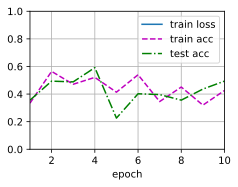

In [23]:
num_epochs, lr = 10, 0.9
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)
# print('num_hiddens1:', num_hiddens1)
# print('num_hiddens2:', num_hiddens2)

为了对学习到的模型进行评估，我们将[**在一些测试数据上应用这个模型**]。


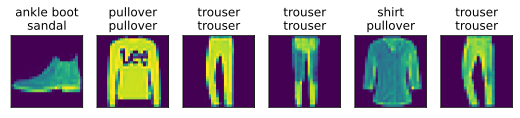

In [24]:
d2l.predict_ch3(net, test_iter, n=6)

## 小结

* 手动实现一个简单的多层感知机是很容易的。然而如果有大量的层，从零开始实现多层感知机会变得很麻烦（例如，要命名和记录模型的参数）。

## 练习

1. 在所有其他参数保持不变的情况下，更改超参数`num_hiddens`的值，并查看此超参数的变化对结果有何影响。确定此超参数的最佳值。
1. 尝试添加更多的隐藏层，并查看它对结果有何影响。
1. 改变学习速率会如何影响结果？保持模型架构和其他超参数（包括轮数）不变，学习率设置为多少会带来最好的结果？
1. 通过对所有超参数（学习率、轮数、隐藏层数、每层的隐藏单元数）进行联合优化，可以得到的最佳结果是什么？
1. 描述为什么涉及多个超参数更具挑战性。
1. 如果想要构建多个超参数的搜索方法，请想出一个聪明的策略。


## 解答
1.  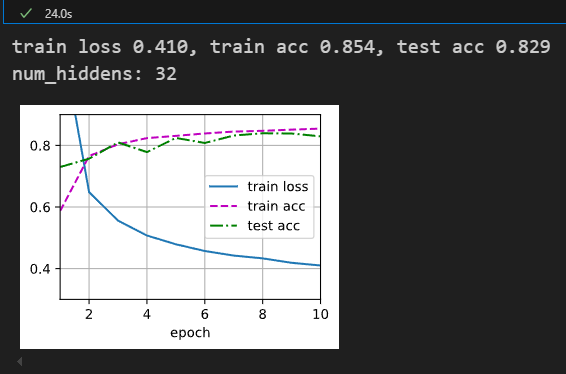
    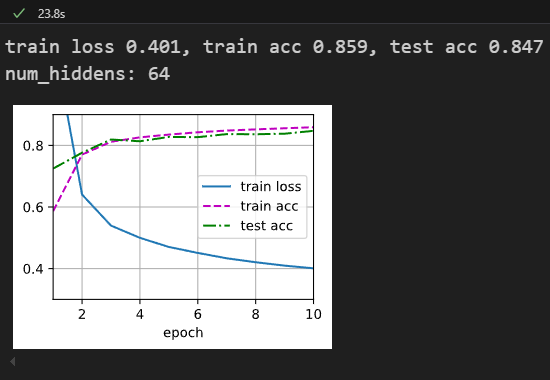 

    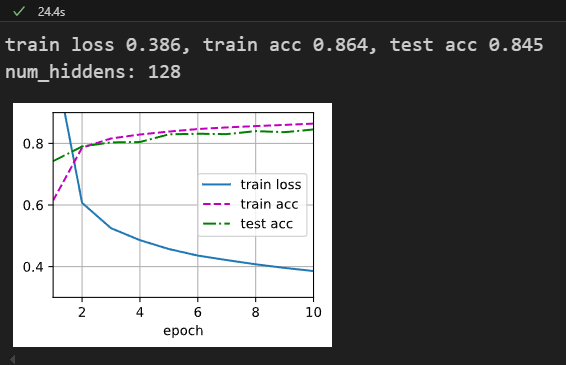 
    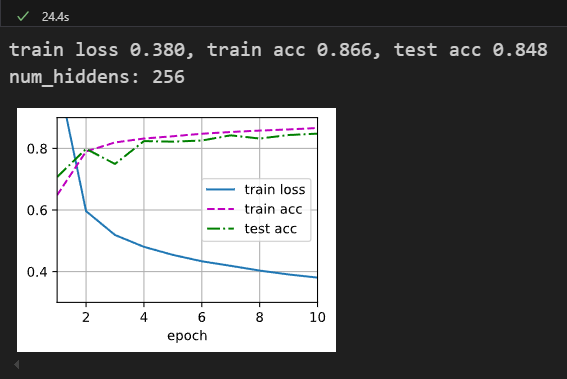

    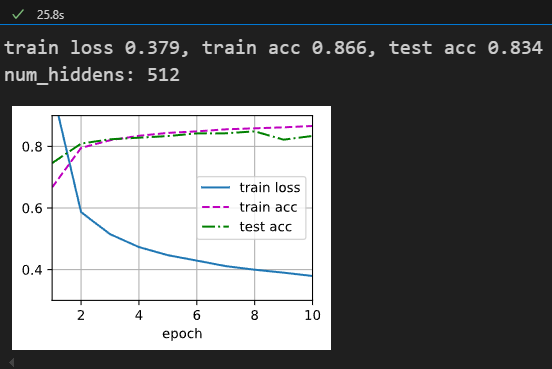

    根据以上运行结果，可以看到num_hiddens为256的时候测试精准度最高，为0.848
    增大num_hiddens会使模型容量变大，提升准确率，但计算开销同样也会增大并可能导致过拟合；减小num_hiddens则相反

2.  如下图所示，增加一个隐藏层，`num_hidden1`为256，`num_hidden2`为128，训练10次，训练结果测试精度为0.838，效果差于前者。

    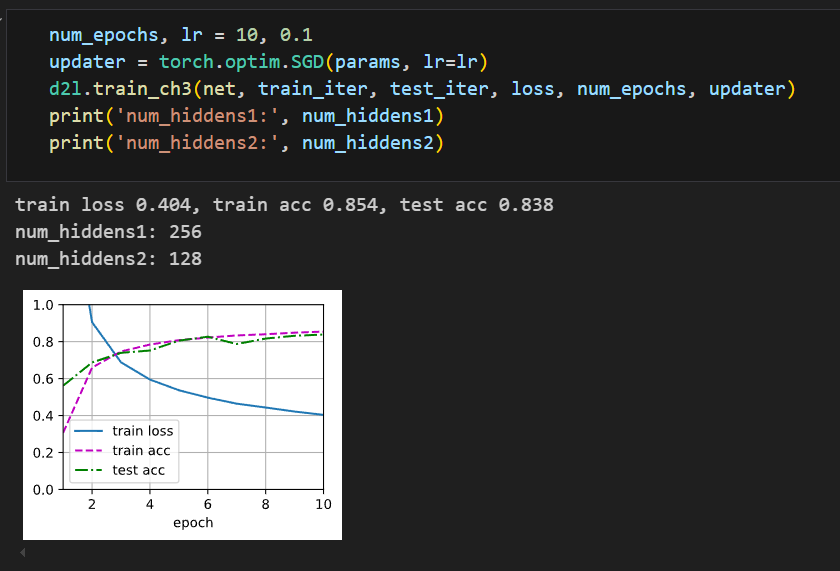

    增加训练次数到100次，得到如下图所示结果，虽然最终测试准确度为0.88，但训练过程中曲线明显震荡，损失精度也在多轮次后存在异常。
    
    这是因为更深的网络和更多的轮次会容易过拟合，导致训练准确率一直上升但测试准确率停滞不前；并且学习率过高也可能会导致优化步长不适，训练结果难以收敛，出现测试准确率震荡和训练损失出现尖峰的情况

    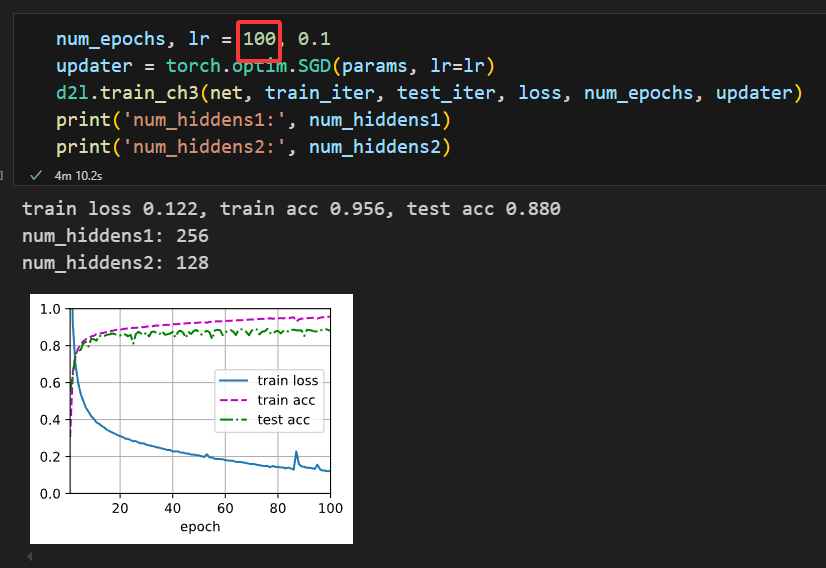

    调节学习率的结果如下，可以看到损失峰值消失，测试精度曲线震荡变小

    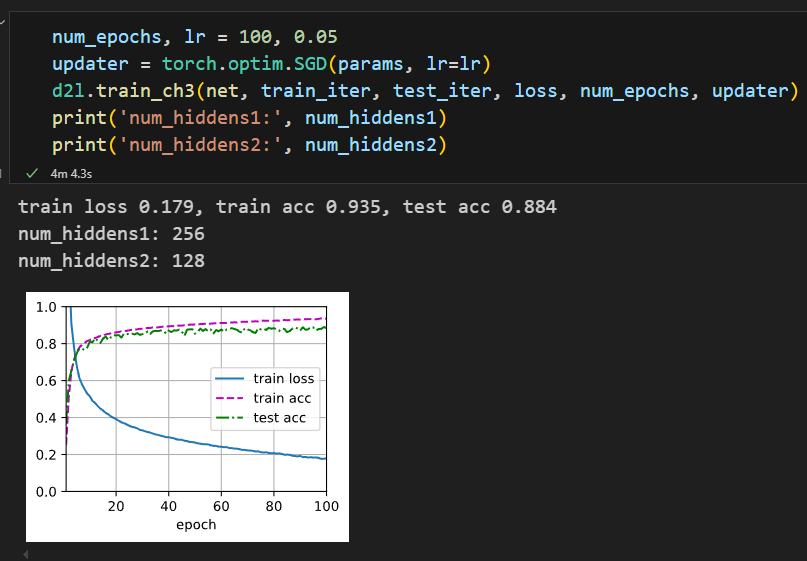
    
    隐藏层会让网络变深，理论上能学习到更具层次性的特征，但同时也会导致训练难度变大，引起梯度消失或爆炸。 $\operatorname{ReLU}(x) = \max(x, 0)$，relu由于最小值取零，可以减轻梯度消失的问题

3. 改变学习率会影响模型梯度更新的步长。学习率过大会导致结果在最优解附近震荡，无法收敛；学习率过小会导致模型收敛慢，或者得到局部最小值
    
    初始设置lr=0.1，结果如下

    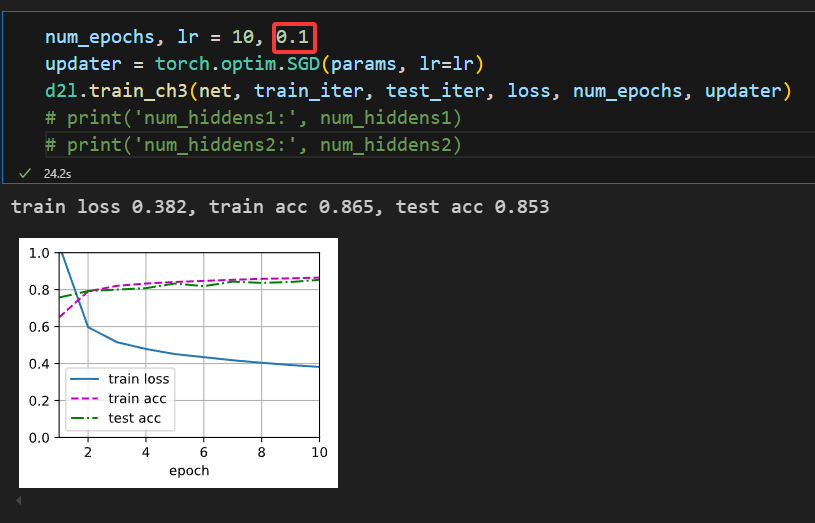

    这里设置lr=0.05，由于收敛速度变慢，可以看到train_loss更大，测试精度变低

    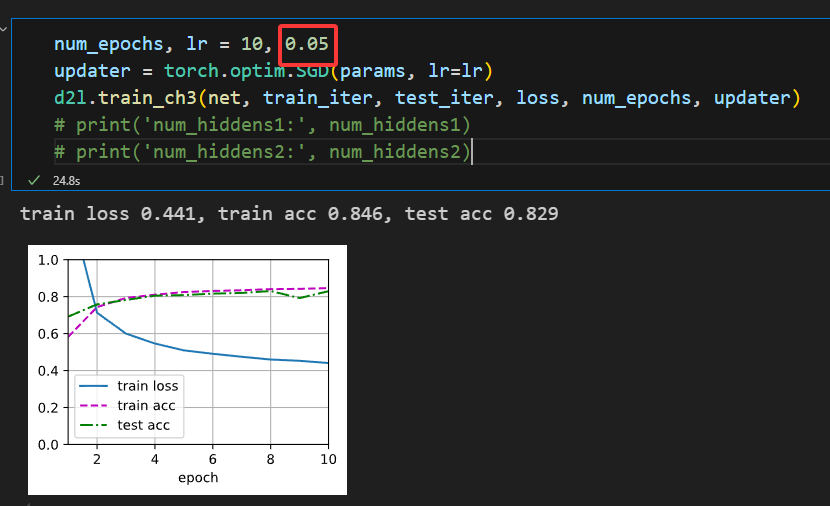

    这里设置lr=0.9，损失曲线过大超出图表范围，而精确度曲线有明显震荡，无法收敛
    
    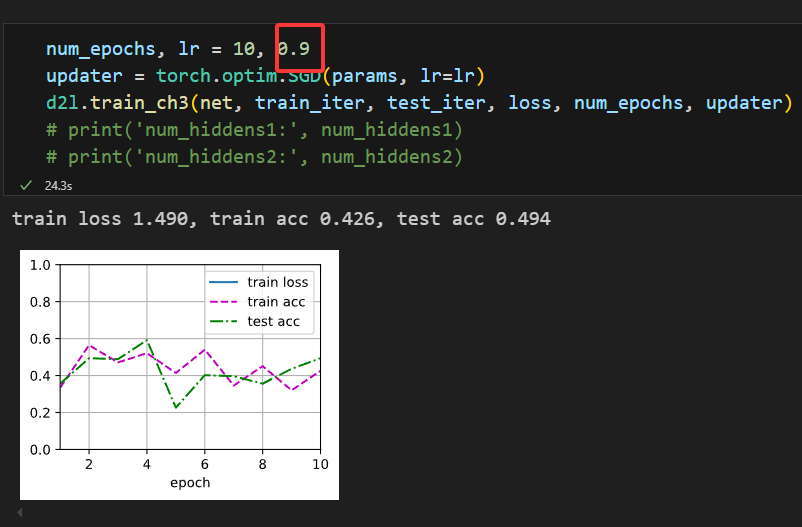

4. 超参数调优，一个可能的优化步骤是确定基础架构，寻找学习率，调整网络结构，微调学习率和轮数。重复以上过程

5.  * 维度问题，例如有4个学习率、4个隐藏单元数、3个隐藏层数选项，总组合数就是 4 * 4 * 3 = 48 种。
    * 超参数之间还有依赖关系，更深的网络可能需要更小的学习率。
    * 模型参数初始化的随机性可能导致同样的超参数训练得到的结果不一样。
    * 计算成本大。

6. 网格搜索，随即搜索，提前终止，贝叶斯优
   
7. 如果net函数的定义如下，会得到一个[batch_size, num_hiddens2]也就是[256,128]维度的矩阵，而我们需要的是[256,10]的矩阵，因为目标分类只有10类。
    在后续的loss计算中并不会发生错误，因为loss接受的参数是(y_hat,y)，会根据真实值y的索引去预测值y_hat中找对应的logits，这只会用到128个输出中的前10个，剩下118个输出虽然被浪费，但并不会导致报错。
    多余的类别分类会导致计算资源浪费，导致收敛速度减慢（稀释softmax）和梯度分散等问题
    ```python
    num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 128  

    W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens1, requires_grad=True) * 0.01)
    b1 = nn.Parameter(torch.zeros(num_hiddens1, requires_grad=True))
    W2 = nn.Parameter(torch.randn(num_hiddens1, num_hiddens2, requires_grad=True) * 0.01)
    b2 = nn.Parameter(torch.zeros(num_hiddens2, requires_grad=True))

    def net(X):
        # 单隐藏层
        X = X.reshape((-1, num_inputs))
        H = relu(X @ W1 + b1)  # 这里“@”代表矩阵乘法
        return H @ W2 + b2 # shape为[256,128]
    ```
    

[Discussions](https://discuss.d2l.ai/t/1804)
